In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:
df = pd.read_csv('data/cls.csv')

In [3]:
df.set_index('Product ID', inplace=True)

In [4]:
df.isnull().sum()

Product Title      0
 Merchant ID       0
 Cluster ID        0
 Cluster Label     0
 Category ID       0
 Category Label    0
dtype: int64

C:\Users\NARINDER\AppData\Local\Temp\ipykernel_9900\1252436048.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


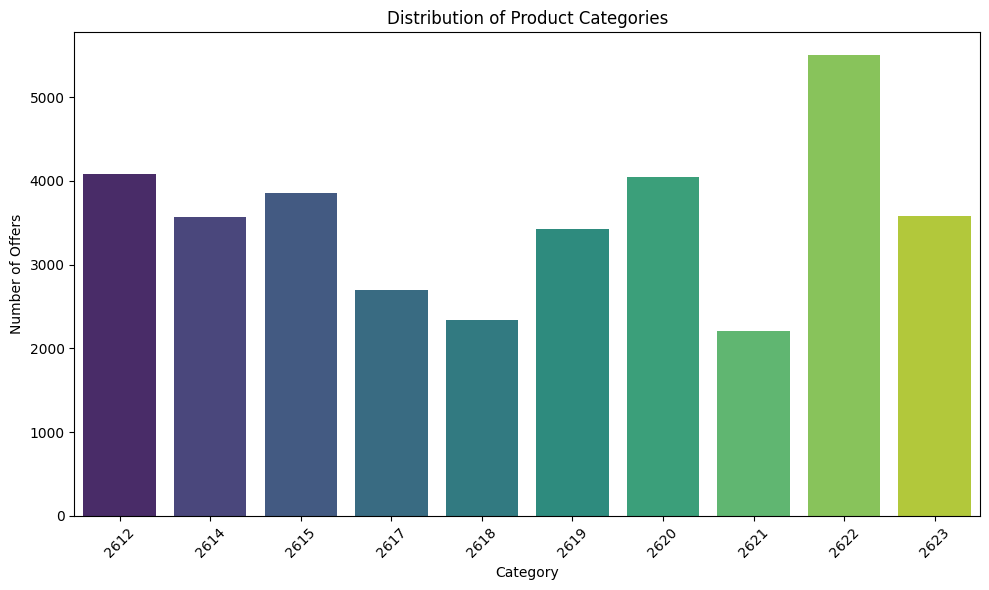

In [5]:
# Count per category
category_counts = df[' Category ID'].value_counts()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Distribution of Product Categories")
plt.xlabel("Category")
plt.ylabel("Number of Offers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\NARINDER\AppData\Local\Temp\ipykernel_9900\1598785820.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=merchant_counts.index, y=merchant_counts.values, palette="mako")


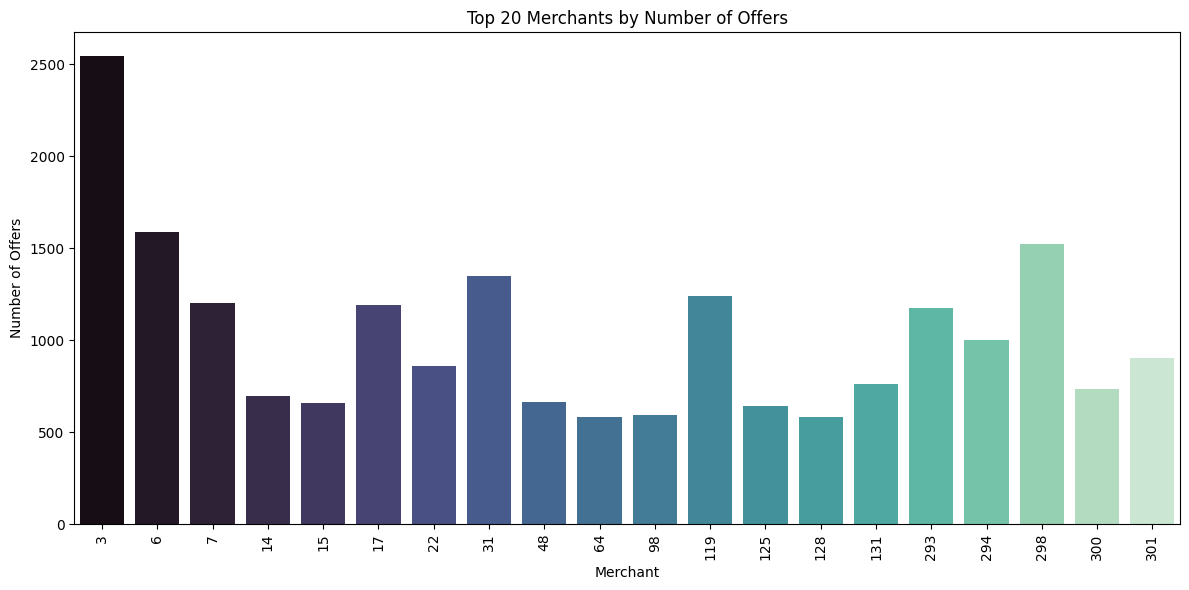

In [6]:
merchant_counts = df[' Merchant ID'].value_counts().head(20)  # Top 20 for visibility

plt.figure(figsize=(12, 6))
sns.barplot(x=merchant_counts.index, y=merchant_counts.values, palette="mako")
plt.title("Top 20 Merchants by Number of Offers")
plt.xlabel("Merchant")
plt.ylabel("Number of Offers")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [7]:
imbalance_ratio = df[' Category ID'].value_counts(normalize=True)
print("Imbalance Ratio:\n", imbalance_ratio)

Imbalance Ratio:
  Category ID
2622    0.155787
2612    0.115573
2620    0.114525
2615    0.109371
2623    0.101498
2614    0.100932
2619    0.096967
2617    0.076378
2618    0.066325
2621    0.062643
Name: proportion, dtype: float64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35311 entries, 1 to 47358
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product Title    35311 non-null  object
 1    Merchant ID     35311 non-null  int64 
 2    Cluster ID      35311 non-null  int64 
 3    Cluster Label   35311 non-null  object
 4    Category ID     35311 non-null  int64 
 5    Category Label  35311 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.9+ MB


In [9]:
# Download NLTK resources (only once)
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Apply to your dataframe
df['cleaned_description'] = df['Product Title'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NARINDER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NARINDER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Encode category labels
category_encoder = LabelEncoder()
df['category_encoded'] = category_encoder.fit_transform(df[' Category ID'])

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['cleaned_description'])
y = df['category_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [15]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62412
[LightGBM] [Info] Number of data points in the train set: 24717, number of used features: 1820
[LightGBM] [Info] Start training from score -2.157719
[LightGBM] [Info] Start training from score -2.293203
[LightGBM] [Info] Start training from score -2.213129
[LightGBM] [Info] Start training from score -2.571973
[LightGBM] [Info] Start training from score -2.713405
[LightGBM] [Info] Start training from score -2.333273
[LightGBM] [Info] Start training from score -2.166861
[LightGBM] [Info] Start training from score -2.770527
[LightGBM] [Info] Start training from score -1.859418
[LightGBM] [Info] Start training from score -2.287607


c:\Users\NARINDER\Desktop\classifier\class\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9461015669246744


In [16]:
def recommend_merchants(category_id, df, top_k=5):
    merchants = df[df[' Category ID'] == category_id][' Merchant ID'].value_counts().head(top_k)
    return merchants.index.tolist()

In [21]:
target_names = [str(cls) for cls in category_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        2612       0.96      0.99      0.97      1224
        2614       0.97      0.98      0.97      1069
        2615       1.00      1.00      1.00      1159
        2617       0.99      0.99      0.99       809
        2618       0.97      0.94      0.95       703
        2619       0.91      0.94      0.92      1027
        2620       0.94      0.94      0.94      1213
        2621       0.94      0.88      0.91       664
        2622       0.92      0.92      0.92      1651
        2623       0.89      0.88      0.89      1075

    accuracy                           0.95     10594
   macro avg       0.95      0.94      0.95     10594
weighted avg       0.95      0.95      0.95     10594



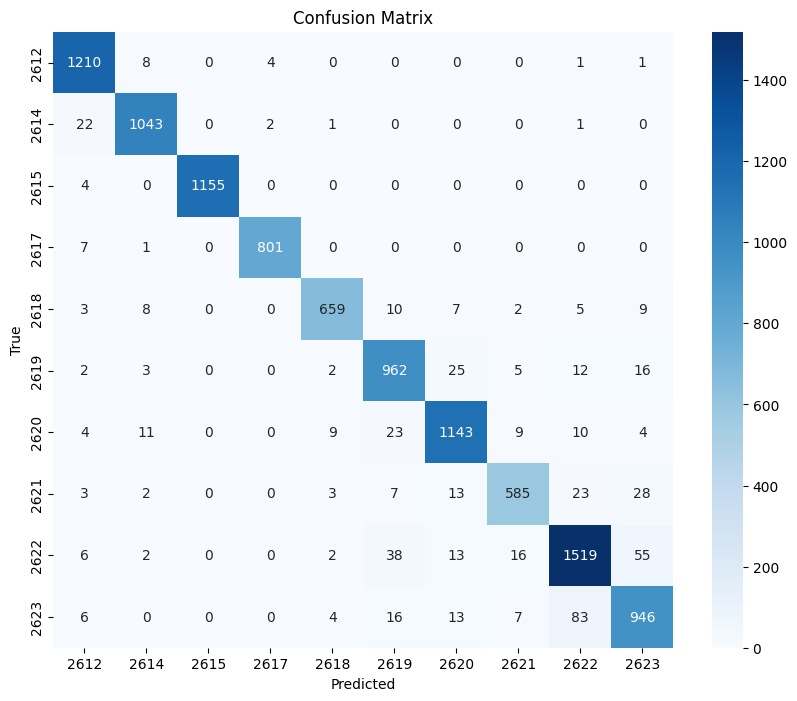

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)

print("Cross-validation accuracies:", scores)
print(f"Mean CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation accuracies: [0.94803908 0.94803172 0.94888134 0.94845653 0.94534126]
Mean CV Accuracy: 0.9477 ± 0.0012
